In [1]:
from google.colab import drive
!rm -rf /content/drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
from pathlib import Path
import pathlib
from torchvision import transforms,models, datasets
from torch import nn, optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.models as model
from torchvision.models import ResNet18_Weights

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


In [ ]:
data_dir = pathlib.Path('/content/drive/MyDrive/archive (4)/BoneFractureYolo8')

In [ ]:
train_image_path = pathlib.Path(data_dir/'train/images')
train_label_path = pathlib.Path(data_dir/'train/labels')

In [ ]:
print(train_image_path)

/content/drive/MyDrive/archive (4)/BoneFractureYolo8/train/images


In [ ]:
def get_sorted_files(image_dir, label_dir):


    train_image_path = Path(image_dir)
    train_label_path = Path(label_dir)


    image_files = sorted(train_image_path.glob('*.jpg'))


    label_files = sorted(train_label_path.glob('*.txt'))

    return image_files, label_files

def get_label(file_path):

    with open(file_path, 'r') as file:
        label_content = file.readline().strip()
        if not label_content:
            return None
        return int(label_content[0])


image_dir = '/content/drive/MyDrive/archive (4)/BoneFractureYolo8/train/images'
label_dir = '/content/drive/MyDrive/archive (4)/BoneFractureYolo8/train/labels'


image_files, label_files = get_sorted_files(image_dir, label_dir)


images = []
labels = []
IMG_SIZE = 256


for image_file, label_file in zip(image_files, label_files):

    image_path = str(image_file)
    label_path = str(label_file)


    label = get_label(label_path)
    if label is None:
        continue


    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    images.append(image)


    labels.append(label)


images = np.array(images)
labels = np.array(labels)

print(f'Loaded {len(images)} images and {len(labels)} labels.')

Loaded 1804 images and 1804 labels.


In [ ]:
label_mapping = {0: 0, 1: 1, 2: 2, 4: 3, 5: 4, 6: 5}

labels_mapped = np.array([label_mapping[label] for label in labels])
labels_one_hot = to_categorical(labels_mapped, num_classes=6)

df_labels = pd.DataFrame(labels_one_hot, columns=[f'Class_{i}' for i in range(6)])

class_counts = df_labels.sum()

print("Class counts:")
print(class_counts)

Class counts:
Class_0    306.0
Class_1    433.0
Class_2    283.0
Class_3    299.0
Class_4    315.0
Class_5    168.0
dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, labels_mapped, test_size=0.2, stratify=labels_mapped)

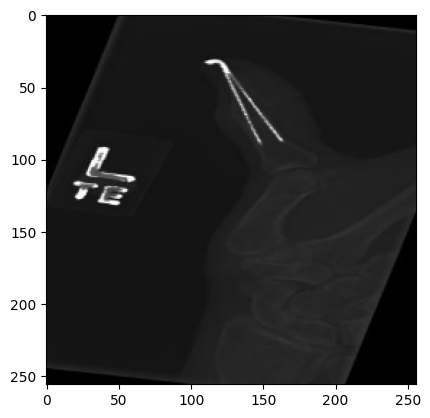

In [ ]:
plt.imshow(X_train[0])

In [ ]:
y_train_one_hot = to_categorical(y_train, num_classes=6)
y_val_one_hot = to_categorical(y_val, num_classes=6)

BATCH_SIZE = 32


datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow(X_train, y_train_one_hot, batch_size=BATCH_SIZE, shuffle=True)
validation_data = datagen.flow(X_val, y_val_one_hot, batch_size=BATCH_SIZE)

print("Training set size:", len(train_data))
print("Validation set size:", len(validation_data))

print("One-hot encoded y_train shape:", y_train_one_hot.shape)
print("One-hot encoded y_val shape:", y_val_one_hot.shape)

Training set size: 46
Validation set size: 12
One-hot encoded y_train shape: (1443, 6)
One-hot encoded y_val shape: (361, 6)


In [ ]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(128, 3, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(6, activation='softmax')
])

model.summary()
model.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 252, 252, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 126, 126, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 124, 124, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 492032)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 492032)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │       2,952,198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,045,446 (11.62 MB)

 Trainable params: 3,045,446 (11.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 452ms/step - accuracy: 0.2696 - loss: 2.2511 - val_accuracy: 0.3934 - val_loss: 1.5378
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - accuracy: 0.5069 - loss: 1.3390 - val_accuracy: 0.4404 - val_loss: 1.4238
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.6634 - loss: 0.8943 - val_accuracy: 0.5069 - val_loss: 1.6434
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.8573 - loss: 0.4617 - val_accuracy: 0.5235 - val_loss: 1.9195
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.9531 - loss: 0.1715 - val_accuracy: 0.5651 - val_loss: 1.8750
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.9751 - loss: 0.1159 - val_accuracy: 0.5873 - val_loss: 2.2106
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.9828 - loss: 0.0567 - val_accuracy: 0.5706 - val_loss: 2.3815
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.9918 - loss: 0.0225 - val_accuracy: 0.6205 - 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

model = keras.models.Sequential([
    keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    keras.layers.Conv2D(16, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(6, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 258064)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 258064)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │       1,548,390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,548,838 (5.91 MB)

 Trainable params: 1,548,838 (5.91 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.2863 - loss: 1.8360 - val_accuracy: 0.3518 - val_loss: 1.6910
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.4327 - loss: 1.5908 - val_accuracy: 0.3850 - val_loss: 1.6365
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4986 - loss: 1.4317 - val_accuracy: 0.4266 - val_loss: 1.5392
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5542 - loss: 1.3447 - val_accuracy: 0.4404 - val_loss: 1.5664
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6202 - loss: 1.2260 - val_accuracy: 0.4377 - val_loss: 1.5066
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6438 - loss: 1.1412 - val_accuracy: 0.4488 - val_loss: 1.4663
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6913 - loss: 1.0611 - val_accuracy: 0.4598 - val_loss: 1.5103
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7176 - loss: 0.9784 - val_accuracy: 0.5291 - 

In [ ]:
test_loss, test_accuracy = model.evaluate(validation_data)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5504 - loss: 1.3597
Test Loss: 1.295494794845581
Test Accuracy: 0.5484764575958252


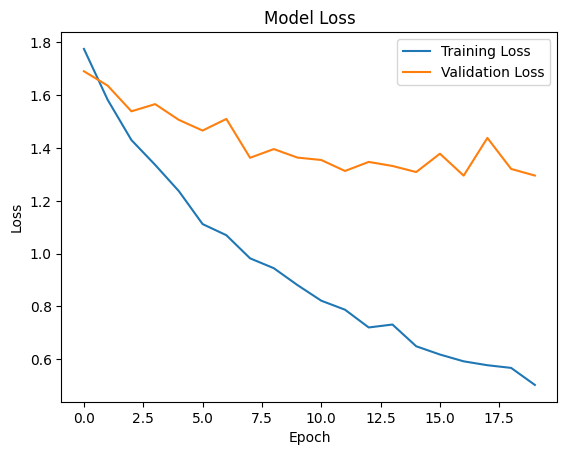

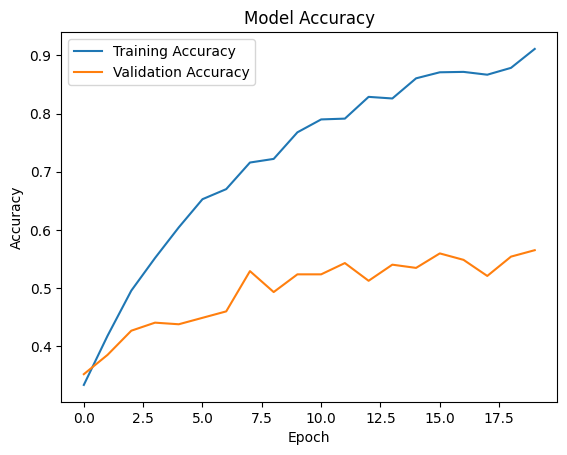

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy values if accuracy was used as a metric
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
model.save('/content/drive/MyDrive/archive (4)/kerasmodel.h5')

In [3]:
from tensorflow.keras.models import load_model
keras_model_path = '/content/drive/MyDrive/archive (4)/kerasmodel.h5'

keras_model = load_model(keras_model_path)

In [4]:
from pathlib import Path

IMG_SIZE = 256
test_image_dir = '/content/drive/MyDrive/archive (4)/bone fracture detection.v4-v4.yolov8/test/images'
X_test = []
for img_path in Path(test_image_dir).glob('*.jpg'):
    img = cv2.imread(str(img_path))
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    X_test.append(img)
X_test = np.array(X_test)

In [5]:
import numpy as np
from pathlib import Path

label_dir = '/content/drive/MyDrive/archive (4)/BoneFractureYolo8/test/labels'
label_files = sorted(Path(label_dir).glob('*.txt'))

y_test = []
X_test_filtered = []

for i, label_file in enumerate(label_files):
    with open(label_file, 'r') as f:
        line = f.readline().strip().split()
        if line:
            label = int(line[0])
            y_test.append(label)
            X_test_filtered.append(X_test[i])

y_test = np.array(y_test)
X_test_filtered = np.array(X_test_filtered)
#update keras_input:
keras_input = X_test_filtered

In [6]:
keras_predictions = keras_model.predict(X_test_filtered)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


In [7]:
import numpy as np
test_data = torch.tensor(X_test_filtered, dtype=torch.float32)

In [8]:
import numpy as np
import torch

X_test = np.array([cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in X_test_filtered])

keras_input = X_test

pytorch_input = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)

In [9]:
keras_predictions = keras_model.predict(keras_input)
keras_predictions = np.argmax(keras_predictions, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step


In [10]:
import numpy as np
from pathlib import Path

label_dir = '/content/drive/MyDrive/archive (4)/BoneFractureYolo8/test/labels'
label_files = sorted(Path(label_dir).glob('*.txt'))

y_test = []
for label_file in label_files:
    with open(label_file, 'r') as f:
      line = f.readline().strip().split()
      if line:
            label = int(line[0])
            y_test.append(label)
y_test = np.array(y_test)

Keras Model - Accuracy: 0.10843373493975904
Keras Model - F1 Score: 0.08415127692236125
Keras Model - Confusion Matrix:
 [[1 1 3 1 6 1 0]
 [4 0 6 4 7 1 0]
 [3 1 5 2 1 1 0]
 [0 0 0 0 0 0 0]
 [3 1 3 3 3 1 0]
 [2 3 3 2 5 0 0]
 [0 1 2 0 1 2 0]]

Keras Model Classification Report:
               precision    recall  f1-score   support

           0       0.08      0.08      0.08        13
           1       0.00      0.00      0.00        22
           2       0.23      0.38      0.29        13
           3       0.00      0.00      0.00         0
           4       0.13      0.21      0.16        14
           5       0.00      0.00      0.00        15
           6       0.00      0.00      0.00         6

    accuracy                           0.11        83
   macro avg       0.06      0.10      0.07        83
weighted avg       0.07      0.11      0.08        83



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

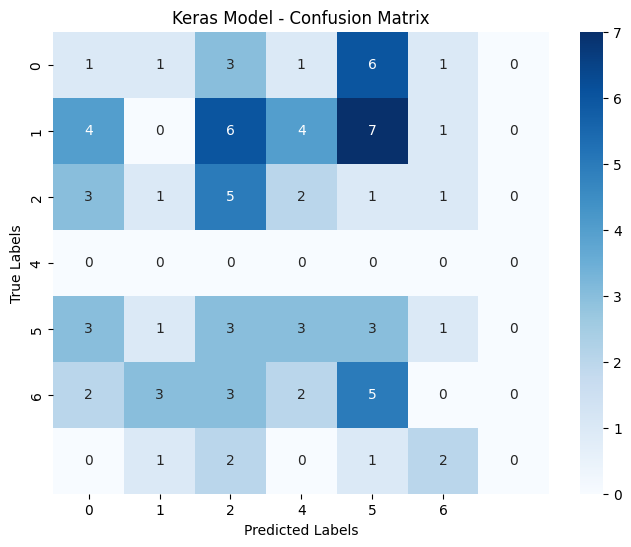

In [12]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
accuracy_keras = accuracy_score(y_test, keras_predictions)
f1_keras = f1_score(y_test, keras_predictions, average='weighted')
conf_matrix_keras = confusion_matrix(y_test, keras_predictions)
print("Keras Model - Accuracy:", accuracy_keras)
print("Keras Model - F1 Score:", f1_keras)
print("Keras Model - Confusion Matrix:\n", conf_matrix_keras)
print("\nKeras Model Classification Report:\n", classification_report(y_test, keras_predictions))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_keras, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Keras Model - Confusion Matrix')
plt.show()